# Example

c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\squidpy\pl\_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


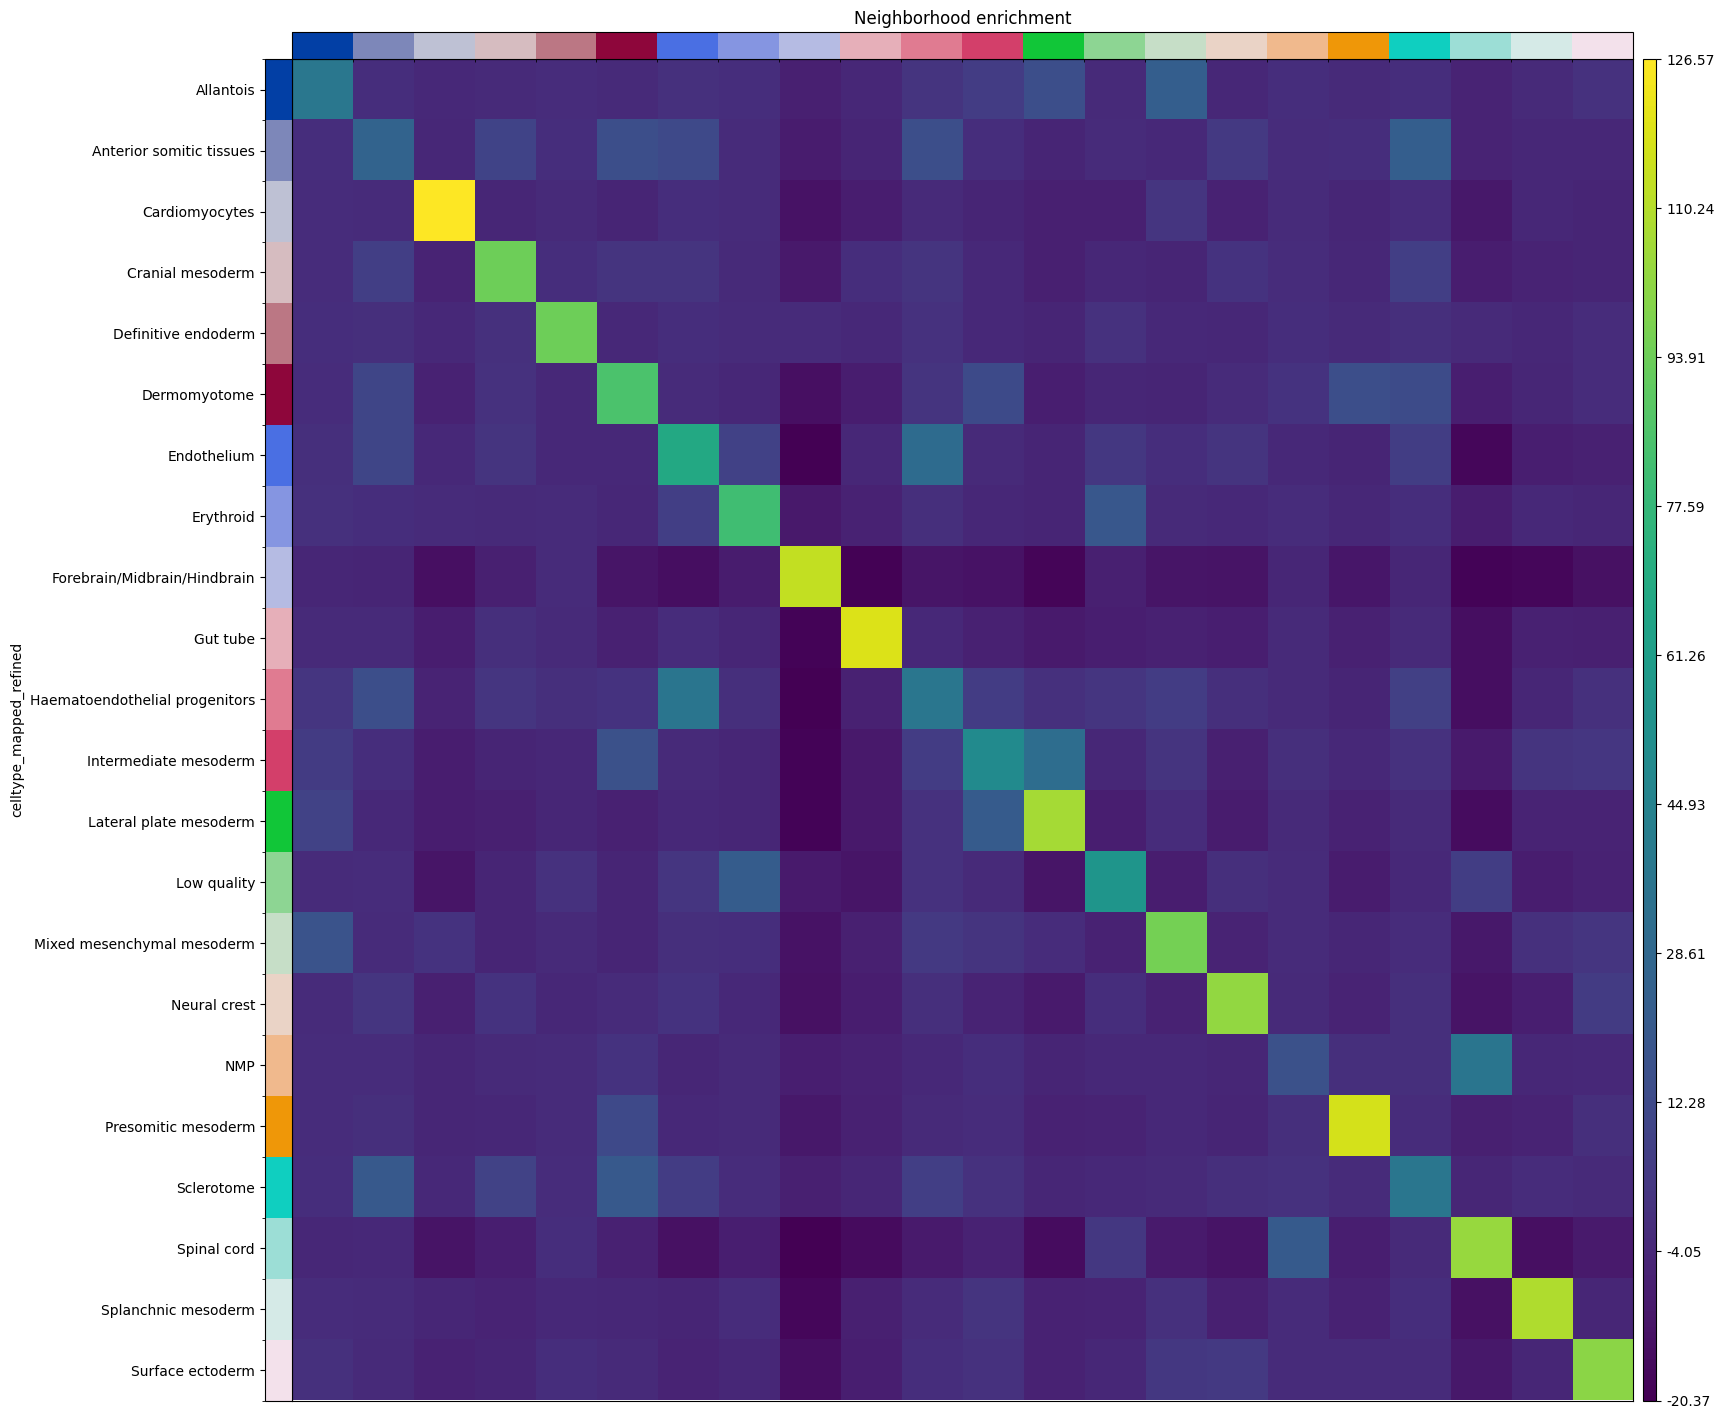

In [3]:
import squidpy as sq
from analytical_nhood_enrichment import nhood_enrichment
# Load example data from Squidpy
adata = sq.datasets.seqfish()

# Create the graph
sq.gr.spatial_neighbors(adata)

# Run the enrichment
nhood_enrichment(adata, cluster_key='celltype_mapped_refined')

# Plot
sq.pl.nhood_enrichment(adata, cluster_key='celltype_mapped_refined')

Reproducing the correlation scores in the pre-print

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr

datasets = [
    {
        'name' : 'Seqfish',
        'adata' : sq.datasets.seqfish(),
        'key' : 'celltype_mapped_refined',
        'library_key' : None
    },
    {
        'name' : 'IMC',
        'adata' : sq.datasets.imc(),
        'key' : 'cell type',
        'library_key' : None

    },
    {
        'name' : 'MERFISH',
        'adata' : sq.datasets.merfish(),
        'key' : 'Cell_class',
        'library_key' : 'batch'
    },
    {
        'name' : 'MIBI-TOF',
        'adata' : sq.datasets.mibitof(),
        'key' : 'Cluster',
        'library_key' : 'batch'
    },
    {
        'name' : 'Visium',
        'adata' : sq.datasets.visium_fluo_adata(),
        'key' : 'cluster',
        'library_key' : None
    },

    {
        'name' : '4i',
        'adata' : sq.datasets.visium_fluo_adata(),
        'key' : 'leiden',
        'library_key' : None
    }
]

def pearson(a: np.ndarray, b: np.ndarray) -> float:
    return pearsonr(a.flatten(), b.flatten()).statistic

def spearman(a: np.ndarray, b: np.ndarray) -> float:
    p, _ = spearmanr(a.flatten(), b.flatten())
    return p

results = {
    'Dataset' : [],
    'Pearson' : [],
    'Spearman' : []
} 

for dataset in datasets:
    name = dataset['name']
    adata = dataset['adata']
    library_key = dataset['library_key']
    cluster_key = dataset['key']

    # Incase several replicates, select first
    if library_key is not None:
        ids = adata.obs[library_key]
        uid = ids.unique()[0]
        adata = adata[adata.obs[library_key] == uid]

    # Compute neighbors
    sq.gr.spatial_neighbors(adata)

    # Compute zscores
    zscore_analytical, _ = nhood_enrichment(adata, cluster_key=cluster_key, copy=True)
    zscore_squidpy, _ = sq.gr.nhood_enrichment(adata, cluster_key=cluster_key, copy=True, show_progress_bar=False)
    
    p, s = pearson(zscore_analytical, zscore_squidpy), spearman(zscore_analytical, zscore_squidpy)

    results['Dataset'].append(name)
    results['Spearman'].append(s)
    results['Pearson'].append(p)

results = pd.DataFrame(results)

c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprec

In [5]:
display(results)

,Dataset,Pearson,Spearman
0,Seqfish,0.986151,0.985734
1,IMC,0.976620,0.989392
2,MERFISH,0.981160,0.987257
3,MIBI-TOF,0.976143,0.979258
4,Visium,0.994370,0.989822
5,4i,0.994420,0.990497


# Timing

In [6]:
import time

def timeit(fun, n=30):
    times = []
    for _ in range(n):
        start = time.time()
        fun()
        stop = time.time()
        elapsed_time = stop - start
        times.append(elapsed_time)
    return np.mean(times), np.std(times)

results_timing = {
    'Dataset' : [],
    'Avg wall clock time [s] (Analytical)' : [],
    'Std wall clock time [s] (Analytical)' : [],
    'Avg wall clock time [s] (Squidpy)' : [],
    'Std wall clock time [s] (Squidpy)' : []
} 

for dataset in datasets:
    name = dataset['name']
    adata = dataset['adata']
    library_key = dataset['library_key']
    cluster_key = dataset['key']

    # Incase several replicates, select first
    if library_key is not None:
        ids = adata.obs[library_key]
        uid = ids.unique()[0]
        adata = adata[adata.obs[library_key] == uid]

    # Compute neighbors
    sq.gr.spatial_neighbors(adata)

    # Compute zscores
    avg_time_analytical, std_time_analytical = timeit(lambda  : nhood_enrichment(adata, cluster_key=cluster_key, copy=False))
    avg_time_squidpy, std_time_squidpy = timeit(lambda : sq.gr.nhood_enrichment(adata, cluster_key=cluster_key, copy=False, show_progress_bar=False))

    results_timing['Dataset'].append(name)
    results_timing['Avg wall clock time [s] (Analytical)'].append(avg_time_analytical)
    results_timing['Std wall clock time [s] (Analytical)'].append(std_time_analytical)
    results_timing['Avg wall clock time [s] (Squidpy)'].append(avg_time_squidpy)
    results_timing['Std wall clock time [s] (Squidpy)'].append(std_time_squidpy)


results_timing = pd.DataFrame(results_timing)

[0.0040781497955322266, 0.0, 0.0, 0.0, 0.0159146785736084, 0.0, 0.0, 0.013269424438476562, 0.0009162425994873047, 0.004960060119628906]
[1.0703964233398438, 1.1242833137512207, 1.1260864734649658, 1.1412839889526367, 1.134291172027588, 1.1013460159301758, 1.1317834854125977, 1.118237018585205, 1.1442432403564453, 1.1042454242706299]
[0.0011551380157470703, 0.0, 0.004691123962402344, 0.001007080078125, 0.002000570297241211, 0.0010013580322265625, 0.0009992122650146484, 0.001999378204345703, 0.001001596450805664, 0.0009982585906982422]
[0.13112688064575195, 0.1299135684967041, 0.12269210815429688, 0.1278371810913086, 0.13436484336853027, 0.1312863826751709, 0.134779691696167, 0.13521623611450195, 0.12628722190856934, 0.13177895545959473]
[0.0, 0.0033426284790039062, 0.0, 0.0050008296966552734, 0.003041505813598633, 0.0014255046844482422, 0.002415180206298828, 0.001008749008178711, 0.0026001930236816406, 0.0]


c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\squidpy\gr\_utils.py:198: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


[0.2146463394165039, 0.20729684829711914, 0.19051623344421387, 0.20106101036071777, 0.1990063190460205, 0.19924688339233398, 0.20886492729187012, 0.20430684089660645, 0.2034609317779541, 0.20528221130371094]
[0.006600618362426758, 0.0017895698547363281, 0.0, 0.0, 0.002068758010864258, 0.0010731220245361328, 0.0, 0.0, 0.0, 0.0]


c:\Users\axela\anaconda3\envs\iss_decoding\lib\site-packages\squidpy\gr\_utils.py:198: ImplicitModificationWarning: Setting element `.obsp['spatial_connectivities']` of view, initializing view as actual.
  obj[key] = data


[0.03826498985290527, 0.037574052810668945, 0.037603139877319336, 0.03817439079284668, 0.0415501594543457, 0.03897500038146973, 0.0388491153717041, 0.033861398696899414, 0.03375840187072754, 0.03232622146606445]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016019105911254883, 0.0, 0.0]
[0.09627842903137207, 0.09914183616638184, 0.10036349296569824, 0.08998560905456543, 0.09865403175354004, 0.09601950645446777, 0.09305429458618164, 0.09530091285705566, 0.09577083587646484, 0.09860992431640625]
[0.010715484619140625, 0.0020418167114257812, 0.0009281635284423828, 0.0010123252868652344, 0.0, 0.0023505687713623047, 0.0006468296051025391, 0.0, 0.0, 0.0]
[0.09763121604919434, 0.09933900833129883, 0.09142661094665527, 0.09676766395568848, 0.09462833404541016, 0.092864990234375, 0.07991337776184082, 0.10936713218688965, 0.09224677085876465, 0.09737896919250488]


In [8]:
results_timing['Speed-up'] = results_timing['Avg wall clock time [s] (Squidpy)'] / results_timing['Avg wall clock time [s] (Analytical)']

In [14]:
display(results_timing)

,Dataset,Avg wall clock time [s] (Analytical),Std wall clock time [s] (Analytical),Avg wall clock time [s] (Squidpy),Std wall clock time [s] (Squidpy),Speed-up
0,Seqfish,0.003914,0.005641,1.119620,0.021207,286.065656
1,IMC,0.001485,0.001196,0.130528,0.003798,87.875861
2,MERFISH,0.001883,0.001600,0.203369,0.006196,107.976253
3,MIBI-TOF,0.001153,0.001972,0.037094,0.002717,32.165685
4,Visium,0.001602,0.004806,0.096318,0.002953,60.126881
5,4i,0.001770,0.003090,0.095156,0.007024,53.775300
